# Melting Point Prediction - Model Training

This notebook trains XGBoost and LightGBM models using molecular descriptors from RDKit and Mordred.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski, rdMolDescriptors
from mordred import Calculator, descriptors
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import warnings
warnings.filterwarnings('ignore')

print("Libraries loaded successfully!")

Libraries loaded successfully!


## 1. Load Data

In [2]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

print(f"Training samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")
print(f"Original features (Group columns): {len([c for c in train_df.columns if c.startswith('Group')])}")

Training samples: 2662
Test samples: 666
Original features (Group columns): 424


## 2. Generate Molecular Descriptors

### 2.1 RDKit Descriptors
Key descriptors related to melting point:
- **MolWt**: Molecular weight
- **LogP**: Lipophilicity
- **TPSA**: Topological polar surface area
- **NumHDonors/Acceptors**: Hydrogen bonding capacity
- **NumAromaticRings**: Pi-stacking potential
- **FractionCSP3**: Molecular flexibility

In [3]:
def compute_rdkit_descriptors(smiles_list):
    """Compute RDKit descriptors"""
    descriptors_list = []
    
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            descriptors_list.append({key: np.nan for key in [
                'MolWt', 'LogP', 'TPSA', 'NumHDonors', 'NumHAcceptors',
                'NumRotatableBonds', 'NumAromaticRings', 'NumHeavyAtoms',
                'FractionCSP3', 'NumRings', 'NumHeteroatoms', 'MolMR',
                'NumValenceElectrons', 'NumRadicalElectrons', 'HallKierAlpha',
                'NumAliphaticRings', 'NumSaturatedRings', 'NumAromaticHeterocycles',
                'NumAliphaticHeterocycles', 'NumSaturatedHeterocycles'
            ]})
            continue
            
        desc = {
            'MolWt': Descriptors.MolWt(mol),
            'LogP': Descriptors.MolLogP(mol),
            'TPSA': Descriptors.TPSA(mol),
            'NumHDonors': Lipinski.NumHDonors(mol),
            'NumHAcceptors': Lipinski.NumHAcceptors(mol),
            'NumRotatableBonds': Lipinski.NumRotatableBonds(mol),
            'NumAromaticRings': rdMolDescriptors.CalcNumAromaticRings(mol),
            'NumHeavyAtoms': Lipinski.HeavyAtomCount(mol),
            'FractionCSP3': rdMolDescriptors.CalcFractionCSP3(mol),
            'NumRings': rdMolDescriptors.CalcNumRings(mol),
            'NumHeteroatoms': rdMolDescriptors.CalcNumHeteroatoms(mol),
            'MolMR': Descriptors.MolMR(mol),
            'NumValenceElectrons': Descriptors.NumValenceElectrons(mol),
            'NumRadicalElectrons': Descriptors.NumRadicalElectrons(mol),
            'HallKierAlpha': Descriptors.HallKierAlpha(mol),
            'NumAliphaticRings': rdMolDescriptors.CalcNumAliphaticRings(mol),
            'NumSaturatedRings': rdMolDescriptors.CalcNumSaturatedRings(mol),
            'NumAromaticHeterocycles': rdMolDescriptors.CalcNumAromaticHeterocycles(mol),
            'NumAliphaticHeterocycles': rdMolDescriptors.CalcNumAliphaticHeterocycles(mol),
            'NumSaturatedHeterocycles': rdMolDescriptors.CalcNumSaturatedHeterocycles(mol),
        }
        descriptors_list.append(desc)
    
    return pd.DataFrame(descriptors_list)

print("Computing RDKit descriptors for training data...")
train_rdkit = compute_rdkit_descriptors(train_df['SMILES'].values)
print("Computing RDKit descriptors for test data...")
test_rdkit = compute_rdkit_descriptors(test_df['SMILES'].values)

print(f"\nRDKit descriptors: {train_rdkit.shape[1]}")

Computing RDKit descriptors for training data...
Computing RDKit descriptors for test data...

RDKit descriptors: 20


### 2.2 Mordred Descriptors

In [4]:
def compute_mordred_descriptors(smiles_list):
    """Compute Mordred descriptors that work for all molecules"""
    mols = [Chem.MolFromSmiles(s) for s in smiles_list]
    
    calc = Calculator(descriptors, ignore_3D=True)
    print(f"Calculating {len(calc.descriptors)} Mordred descriptors...")
    df = calc.pandas(mols)
    
    df = df.apply(pd.to_numeric, errors='coerce')
    valid_cols = df.columns[df.notna().all()].tolist()
    df_clean = df[valid_cols]
    df_clean = df_clean.loc[:, df_clean.std() > 0]
    
    print(f"Valid descriptors (no NaN, non-zero variance): {df_clean.shape[1]}")
    return df_clean

print("Computing Mordred descriptors for training data...")
train_mordred = compute_mordred_descriptors(train_df['SMILES'].values)

print("\nComputing Mordred descriptors for test data...")
test_mordred = compute_mordred_descriptors(test_df['SMILES'].values)

# Keep only common columns
common_cols = list(set(train_mordred.columns) & set(test_mordred.columns))
train_mordred = train_mordred[common_cols]
test_mordred = test_mordred[common_cols]

print(f"\nFinal Mordred descriptors: {len(common_cols)}")

Computing Mordred descriptors for training data...
Calculating 1613 Mordred descriptors...
c:\Users\tkasiror\Desktop\Thermophysical Property Melting Point\venv\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\tkasiror\Desktop\Thermophysical Property Melting Point\venv\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\tkasiror\Desktop\Thermophysical Property Melting Point\venv\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\tkasiror\Desktop\Thermophysical Property Melting Point\venv\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\tkasiror

## 3. Combine All Features

In [5]:
# Original group features
group_cols = [col for col in train_df.columns if col.startswith('Group')]
train_groups = train_df[group_cols]
test_groups = test_df[group_cols]

# Combine all features
X_train = pd.concat([
    train_groups.reset_index(drop=True),
    train_rdkit.reset_index(drop=True),
    train_mordred.reset_index(drop=True)
], axis=1)

X_test = pd.concat([
    test_groups.reset_index(drop=True),
    test_rdkit.reset_index(drop=True),
    test_mordred.reset_index(drop=True)
], axis=1)

y_train = train_df['Tm']

# Clean data
X_train = X_train.fillna(0).replace([np.inf, -np.inf], 0)
X_test = X_test.fillna(0).replace([np.inf, -np.inf], 0)

print(f"Feature breakdown:")
print(f"  - Original Group features: {len(group_cols)}")
print(f"  - RDKit descriptors: {train_rdkit.shape[1]}")
print(f"  - Mordred descriptors: {train_mordred.shape[1]}")
print(f"  - Total features: {X_train.shape[1]}")

Feature breakdown:
  - Original Group features: 424
  - RDKit descriptors: 20
  - Mordred descriptors: 882
  - Total features: 1326


## 4. Train and Evaluate Models

In [6]:
# Define models
xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

lgbm_model = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

def evaluate_model(model, X, y, model_name):
    """Evaluate model using 5-fold cross-validation"""
    print(f"\n{'='*55}")
    print(f"  {model_name}")
    print('='*55)
    
    y_pred_cv = cross_val_predict(model, X, y, cv=kfold)
    
    rmse = np.sqrt(mean_squared_error(y, y_pred_cv))
    mae = mean_absolute_error(y, y_pred_cv)
    r2 = r2_score(y, y_pred_cv)
    
    print(f"\n  Cross-Validation Results (5-Fold):")
    print(f"    RMSE: {rmse:.4f}")
    print(f"    MAE:  {mae:.4f}")
    print(f"    R²:   {r2:.4f}")
    
    print(f"\n  Training on full dataset...")
    model.fit(X, y)
    
    return model, {'RMSE': rmse, 'MAE': mae, 'R2': r2}, y_pred_cv

In [7]:
print("\n" + "="*60)
print("  MODEL EVALUATION WITH ENHANCED FEATURES")
print("="*60)

xgb_trained, xgb_metrics, xgb_cv_pred = evaluate_model(xgb_model, X_train, y_train, "XGBoost")
lgbm_trained, lgbm_metrics, lgbm_cv_pred = evaluate_model(lgbm_model, X_train, y_train, "LightGBM")


  MODEL EVALUATION WITH ENHANCED FEATURES

  XGBoost

  Cross-Validation Results (5-Fold):
    RMSE: 43.4959
    MAE:  27.9398
    R²:   0.7388

  Training on full dataset...

  LightGBM

  Cross-Validation Results (5-Fold):
    RMSE: 44.4390
    MAE:  28.9562
    R²:   0.7273

  Training on full dataset...


## 5. Results Summary

In [8]:
print("\n" + "="*60)
print("  EVALUATION SUMMARY")
print("="*60)

results_df = pd.DataFrame({
    'Metric': ['RMSE', 'MAE', 'R²'],
    'XGBoost': [f"{xgb_metrics['RMSE']:.4f}", f"{xgb_metrics['MAE']:.4f}", f"{xgb_metrics['R2']:.4f}"],
    'LightGBM': [f"{lgbm_metrics['RMSE']:.4f}", f"{lgbm_metrics['MAE']:.4f}", f"{lgbm_metrics['R2']:.4f}"]
})

def get_best(metric, xgb_val, lgbm_val):
    if metric == 'R²':
        return 'XGBoost' if float(xgb_val) > float(lgbm_val) else 'LightGBM'
    return 'XGBoost' if float(xgb_val) < float(lgbm_val) else 'LightGBM'

results_df['Best'] = results_df.apply(lambda r: get_best(r['Metric'], r['XGBoost'], r['LightGBM']), axis=1)

print("\n" + results_df.to_string(index=False))


  EVALUATION SUMMARY

Metric XGBoost LightGBM    Best
  RMSE 43.4959  44.4390 XGBoost
   MAE 27.9398  28.9562 XGBoost
    R²  0.7388   0.7273 XGBoost


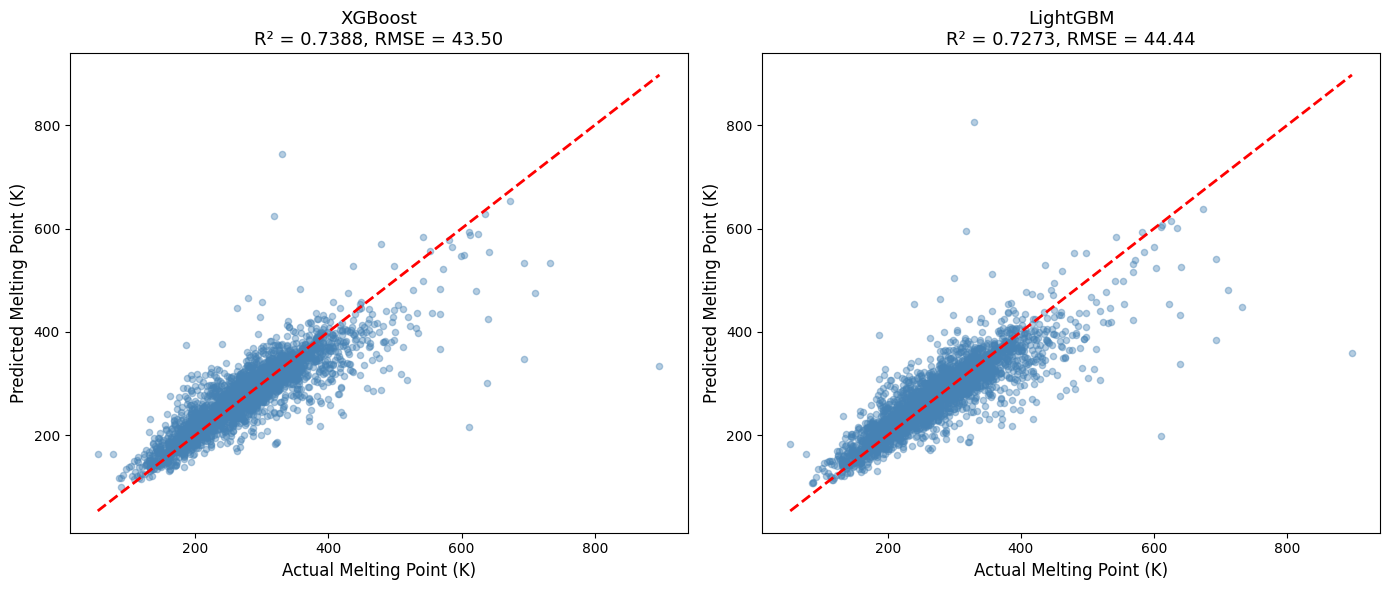

Saved: actual_vs_predicted.png


In [9]:
# Actual vs Predicted plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for ax, pred, name, metrics in zip(axes, [xgb_cv_pred, lgbm_cv_pred], 
                                     ['XGBoost', 'LightGBM'],
                                     [xgb_metrics, lgbm_metrics]):
    ax.scatter(y_train, pred, alpha=0.4, s=20, c='steelblue')
    ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', linewidth=2)
    ax.set_xlabel('Actual Melting Point (K)', fontsize=12)
    ax.set_ylabel('Predicted Melting Point (K)', fontsize=12)
    ax.set_title(f'{name}\nR² = {metrics["R2"]:.4f}, RMSE = {metrics["RMSE"]:.2f}', fontsize=13)

plt.tight_layout()
plt.savefig('actual_vs_predicted.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: actual_vs_predicted.png")

## 6. Feature Importance

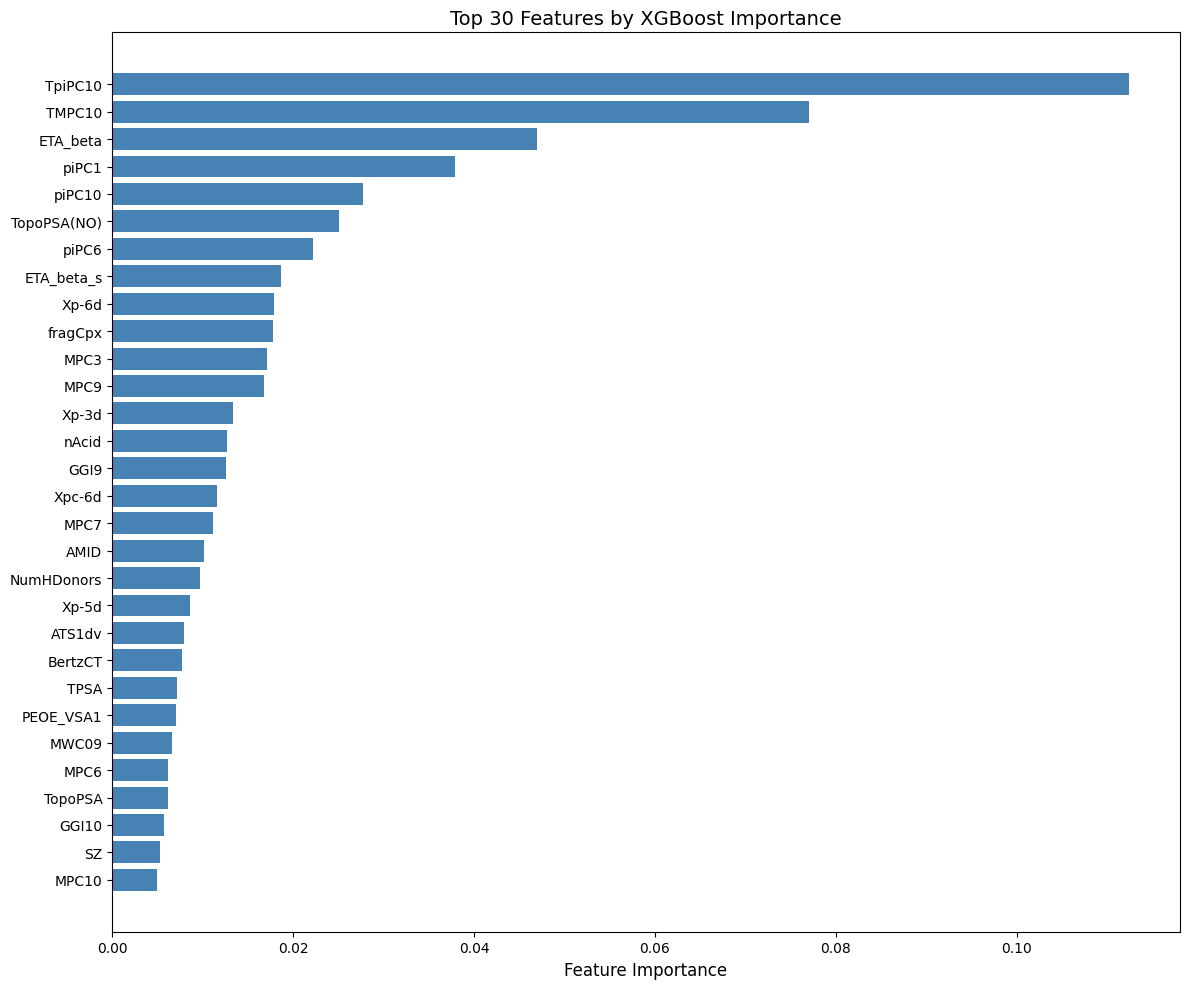

Saved: feature_importance.png

Top 20 Most Important Features:
    feature  importance
    TpiPC10    0.112410
     TMPC10    0.076994
   ETA_beta    0.046918
      piPC1    0.037860
     piPC10    0.027768
TopoPSA(NO)    0.025127
      piPC6    0.022240
 ETA_beta_s    0.018648
      Xp-6d    0.017867
    fragCpx    0.017790
       MPC3    0.017171
       MPC9    0.016843
      Xp-3d    0.013310
      nAcid    0.012713
       GGI9    0.012560
     Xpc-6d    0.011593
       MPC7    0.011144
       AMID    0.010142
 NumHDonors    0.009673
      Xp-5d    0.008620


In [10]:
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_trained.feature_importances_
}).sort_values('importance', ascending=False)

top_30 = feature_importance.head(30)

fig, ax = plt.subplots(figsize=(12, 10))
ax.barh(range(len(top_30)), top_30['importance'].values, color='steelblue')
ax.set_yticks(range(len(top_30)))
ax.set_yticklabels(top_30['feature'].values)
ax.set_xlabel('Feature Importance', fontsize=12)
ax.set_title('Top 30 Features by XGBoost Importance', fontsize=14)
ax.invert_yaxis()

plt.tight_layout()
plt.savefig('feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: feature_importance.png")

print("\nTop 20 Most Important Features:")
print(feature_importance.head(20).to_string(index=False))

## 7. Generate Predictions

In [11]:
xgb_predictions = xgb_trained.predict(X_test)
lgbm_predictions = lgbm_trained.predict(X_test)

# Save predictions
xgb_submission = pd.DataFrame({'id': test_df['id'], 'Tm': xgb_predictions})
lgbm_submission = pd.DataFrame({'id': test_df['id'], 'Tm': lgbm_predictions})

xgb_submission.to_csv('submission_xgboost_enhanced.csv', index=False)
lgbm_submission.to_csv('submission_lightgbm_enhanced.csv', index=False)

print("Predictions saved:")
print("  - submission_xgboost_enhanced.csv")
print("  - submission_lightgbm_enhanced.csv")

print(f"\nTest predictions statistics:")
print(f"  XGBoost  - Min: {xgb_predictions.min():.2f}, Max: {xgb_predictions.max():.2f}, Mean: {xgb_predictions.mean():.2f}")
print(f"  LightGBM - Min: {lgbm_predictions.min():.2f}, Max: {lgbm_predictions.max():.2f}, Mean: {lgbm_predictions.mean():.2f}")

Predictions saved:
  - submission_xgboost_enhanced.csv
  - submission_lightgbm_enhanced.csv

Test predictions statistics:
  XGBoost  - Min: 118.27, Max: 613.66, Mean: 275.20
  LightGBM - Min: 118.51, Max: 616.18, Mean: 275.45
